In [28]:
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import time
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from collections import defaultdict
import itertools
from urllib.parse import parse_qs
import glob
import matplotlib.pylab as plt
from collections import Counter
import collections
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import csv

In [29]:
def get_job_links_page(page):
    base_url = "https://www.indeed.com/jobs?"
    params = {'q': 'data scientist', 
             'l': 'Boulder, CO'}
    

    # start = "https://www.indeed.com/jobs?q=Data+Scientist&l=Denver%2C+CO"
    # use a fake header
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.87 Safari/537.36'}
    params['start'] = 10 * (page-1)

    page = requests.get(base_url, params=params, headers=headers)
    # test = requests.get(start, headers=headers)
    
    soup = BeautifulSoup(page.text, "html.parser")
    links = soup.find_all("a")
    
    # build a list of links
    some_links = []

    for l in links:
        try:
            hyperlink = l.attrs.get('href')
            if "/rc/clk?" in hyperlink:
                some_links.append(l.attrs.get('href'))
        except:
            pass
    
    job_links = ["https://www.indeed.com{}".format(x)
             for x in some_links
             ]
    
    return job_links


In [5]:
links = [get_job_links_page(x) for x in tqdm(range(1, 100))] # getting a link for 39 pages 

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [17:17<00:00, 10.48s/it]


In [6]:
len(links)

99

In [7]:
merged = list(itertools.chain(*links))
len(merged)
merged[0] # getting a link for 39 pages 

'https://www.indeed.com/rc/clk?jk=0adac19f5e68e118&fccid=3d2456270cbb298b&vjs=3'

In [30]:
def get_filename_from_url(some_url):
    parsed = parse_qs(some_url)
    fccid =  parsed.get('fccid')[0]
    other_id = parsed.get('https://www.indeed.com/rc/clk?jk')[0]
    return fccid+other_id+ ".html"

In [ ]:
get_filename_from_url(merged[0]) # file name for each html file

In [9]:
len(set([get_filename_from_url(x) for x in merged])) # the total number of html files(jobs) parsed and saved locally. 

466

In [31]:
#downloading each html file as a soup object
def download_job_page(link):
    save_name = get_filename_from_url(link)
    
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.87 Safari/537.36'}
    test = requests.get(link, headers=headers)
    soup = BeautifulSoup(test.text, "html.parser")
    
    with open('data_scienceBoulder_{}'.format(save_name), 'w') as f:
        f.write(str(soup))

In [11]:
for link in tqdm(merged):
    try:
        download_job_page(link)
    except Exception as e:
        print(str(e), link)
    finally:
        time.sleep(1)


 12%|█████████▋                                                                    | 120/962 [25:37<2:59:49, 12.81s/it]

'charmap' codec can't encode character '\u27a2' in position 145549: character maps to <undefined> https://www.indeed.com/rc/clk?jk=ebd7f29accaa209e&fccid=e370394a608927d2&vjs=3


100%|██████████████████████████████████████████████████████████████████████████████| 962/962 [1:35:45<00:00,  5.97s/it]


In [32]:
html = glob.glob('*.html')
len(html) # the total number of html files(jobs) parsed and saved locally. 

466

In [33]:
html_divs = []
columns = ['company', 'location', 'jobtitle', 'job_summary', 'type']
jobs_df = pd.DataFrame(index=html, columns=columns)

for html_file in html:
    with open(html_file, 'r',encoding="ISO-8859-1") as f:
        _data = BeautifulSoup(f.read(), "html.parser")
        try:
            has_span_job_summary = _data.find("span", id="job_summary").get_text()
            html_divs.append(has_span_job_summary)
            jobs_df['company'][html_file] = _data.find("span", "company").get_text()
        except:
            print('The company field does not exist in: ' + html_file)
        try:
            jobs_df['location'][html_file] = _data.find("span", "location").get_text()
        except:
            print('The location field does not exist in: ' + html_file)
        try:
            jobs_df['jobtitle'][html_file] = _data.find("b", "jobtitle").get_text()
        except:
            print('The jobtitle field does not exist in: ' + html_file)
        try:
            jobs_df['job_summary'][html_file] = _data.find("span", id="job_summary").get_text()
        except:
            print('The job summary field does not exist in: ' + html_file)
        
len(html_divs) # total numbers of job postings saved locally. 


The company field does not exist in: data_scienceBoulder_e370394a608927d2ebd7f29accaa209e.html
The location field does not exist in: data_scienceBoulder_e370394a608927d2ebd7f29accaa209e.html
The jobtitle field does not exist in: data_scienceBoulder_e370394a608927d2ebd7f29accaa209e.html
The job summary field does not exist in: data_scienceBoulder_e370394a608927d2ebd7f29accaa209e.html


465

In [34]:
jobs = pd.DataFrame(html_divs)
jobs.columns = ['job_summary']
jobs.head(20)

job_summary
0   Exponent is a leading engineering and scientif...
1   Researched and relatable, science-driven and s...
2   Duties\nSummary\n\nThis position is located in...
3   Job Summary\n\nThe Research Department of Rock...
4   Job Summary\n\nRADARS® System Business Manager...
5   Location(s): CO - Denver\n\nAre you looking fo...
6   Location(s): CO - Denver; MN - Minneapolis\n\n...
7   Analyze existing Cassini CIRS data to search f...
8   Carry out an independent research program on p...
9   Description:\nPlan, organize and control an as...
10  About the Opportunity\nWe are looking for a ta...
11  Agilent inspires and supports discoveries that...
12  TLI Solutions is a trusted team of scientists,...
13  TLI Solutions is a trusted team of scientists,...
14  Versar is seeking Staff to Senior-Level Enviro...
15  Grounded in safety, quality, and ethics, our e...
16  Innovate. Collaborate. Shine. Lighthouse  KPM...
17  Innovate. Collaborate. Shine. Lighthouse  KPM...
18  Known for being a great place to work and buil...
19  Known for being a great place to work and buil...

In [35]:
jobs.shape

(465, 1)

In [36]:
df1=pd.read_csv('hacker_news.csv')
df1['company'] = ""
df1['location'] = ""
df1['jobtitle'] = ""
df1['type'] = ""
df1['partitions'] = 0
# del df1['source']
df1.rename(columns={'desc': 'job_summary'}, inplace=True)
df1 = df1.drop_duplicates()
for i, row in df1.iterrows():
    s=row['job_summary']
    sp = [x.strip() for x in s.split('|')]
    df1.loc[i,('partitions')] = len(sp)
    if len(sp) > 1:
        df1.loc[i,('company')] = sp[0]
    if len(sp) == 2:
        sp1 = sp[1].split('<p>')
        df1.loc[i,('location')] = sp1[0]
        sp2 = sp1[1].split(':')
        if len(sp2) == 1:
            df1.loc[i,('job_summary')] = sp1[1]
        if len(sp2) == 2:
            df1.loc[i,('jobtitle')] = sp2[0]
            df1.loc[i,('job_summary')] = sp2[1]
    if len(sp) == 3:
       df1.loc[i,('location')] = sp[1]
       df1.loc[i,('jobtitle')] = sp[1]
       df1.loc[i,('job_summary')] = sp[2]
    if len(sp) > 3:
       df1.loc[i,('location')] = sp[1] + ' ' + sp[2]
       df1.loc[i,('jobtitle')] = sp[1] + ' ' + sp[2]
       df1.loc[i,('job_summary')] = sp[-1]
    if len(sp) > 4:
       df1.loc[i,('type')] = ' '.join(sp[3:-1]) 

In [37]:
df1 = df1[['company', 'location', 'jobtitle', 'job_summary', 'type']]
all_jobs=pd.concat([df1,jobs_df])
all_jobs.shape

(2983, 5)

In [38]:
all_jobs.job_summary.unique().shape

(2970,)

In [39]:
def load_skills_list():
    import pandas as pd
    skills = pd.read_csv('skill_phrases-JBM.csv', encoding="ISO-8859-1")
    skills.columns = ['skill_name']
    skills['skill_name'] = skills.skill_name.map(lambda x: 
                                               x.lower().strip())
    return skills.skill_name.tolist()


In [40]:
def load_skills_df():
    skills = pd.read_csv('skill_phrases_purged-JBM.csv', usecols=['Skill Name', 'I Have It']).fillna(False)
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9#+-]+')
    skills['WL'] = [tokenizer.tokenize(skill_phrase) for skill_phrase in skills['Skill Name']]
    return skills


In [41]:
list_of_skills = load_skills_list()
skills = load_skills_df()


In [14]:
#make a big string of all job descriptions
job_string = " ".join(all_jobs.job_summary.tolist())
job_tokens = nltk.word_tokenize(job_string)
job_tokens = [word for word in job_tokens if len(word) >= 1] # remove space 
job_tokens = [word for word in job_tokens if not word in stop_words] # remove english language stop words 
job_tokens = [word.lower().strip() for word in job_tokens if not word in string.punctuation]

assert(type(job_tokens) == list)

filtered = Counter([x for x in job_tokens if x in list_of_skills])

In [15]:
filtered.most_common(50) # looking across skill frequency for all jobs, one way to do it

[('development', 3180),
 ('software', 3088),
 ('analysis', 2657),
 ('research', 1893),
 ('design', 1852),
 ('engineering', 1831),
 ('communication', 1405),
 ('engineers', 1339),
 ('analyst', 1297),
 ('analytics', 1138),
 ('it', 935),
 ('python', 856),
 ('developer', 856),
 ('analytical', 848),
 ('manage', 837),
 ('web', 826),
 ('stack', 823),
 ('sql', 749),
 ('planning', 710),
 ('leadership', 707),
 ('access', 677),
 ('code', 673),
 ('analyze', 640),
 ('excel', 625),
 ('models', 597),
 ('react', 575),
 ('finance', 556),
 ('bi', 540),
 ('analysts', 528),
 ('cloud', 524),
 ('modeling', 519),
 ('database', 507),
 ('mobile', 492),
 ('programming', 475),
 ('writing', 473),
 ('backend', 473),
 ('aws', 472),
 ('statistical', 462),
 ('javascript', 437),
 ('healthcare', 434),
 ('java', 396),
 ('social', 392),
 ('agile', 392),
 ('interpersonal', 373),
 ('model', 369),
 ('hardware', 367),
 ('databases', 355),
 ('collaborate', 354),
 ('ms', 348),
 ('frontend', 346)]

In [16]:
def get_matching_skills_for_search_kw(search_term, dataframe_name, load_skills_list):

    matches = defaultdict(int)

    for index, row in dataframe_name.iterrows():
        job_desc = row.job_summary # local specificity 
        job_tokens = nltk.word_tokenize(job_desc)
        job_tokens = [word for word in job_tokens if len(word) >= 2] # remove space 
        job_tokens = [word for word in job_tokens if not word in stop_words] # remove english language stop words 
        job_tokens = [word.lower().strip() for word in job_tokens if not word in string.punctuation ] 
        
        if search_term in job_tokens:
            for skill in list_of_skills:
                if (skill in job_tokens):
                    matches[skill] += 1
                    
    return Counter(matches)

In [17]:
LIST_OF_QUERIES = ['sql', 'python', 'javascript', 'java', 'excel'] # obviously use more

all_matches =  { query: get_matching_skills_for_search_kw(query, 
                                                all_jobs, 
                                                list_of_skills) 
               for query in LIST_OF_QUERIES  }

In [18]:
all_matches

{'sql': Counter({'it': 146,
          'developer': 83,
          '.net': 26,
          'angular': 11,
          'github': 4,
          'stack': 63,
          'sql': 474,
          'django': 12,
          'php': 33,
          'development': 315,
          'javascript': 243,
          'java': 166,
          'software': 276,
          'python': 356,
          'ruby': 32,
          'mobile': 55,
          'web': 246,
          'node.js': 28,
          'jquery': 52,
          'mysql': 24,
          'postgres': 10,
          'server': 111,
          'android': 17,
          'ms': 99,
          'ios': 15,
          'react': 31,
          'models': 132,
          'hadoop': 56,
          'linux': 78,
          'css': 28,
          'js': 9,
          'frontend': 10,
          'azure': 25,
          'cloud': 63,
          'c++': 20,
          'controls': 19,
          'modeling': 232,
          'docker': 23,
          'databases': 115,
          'restful': 6,
          'backend': 50,
          'i

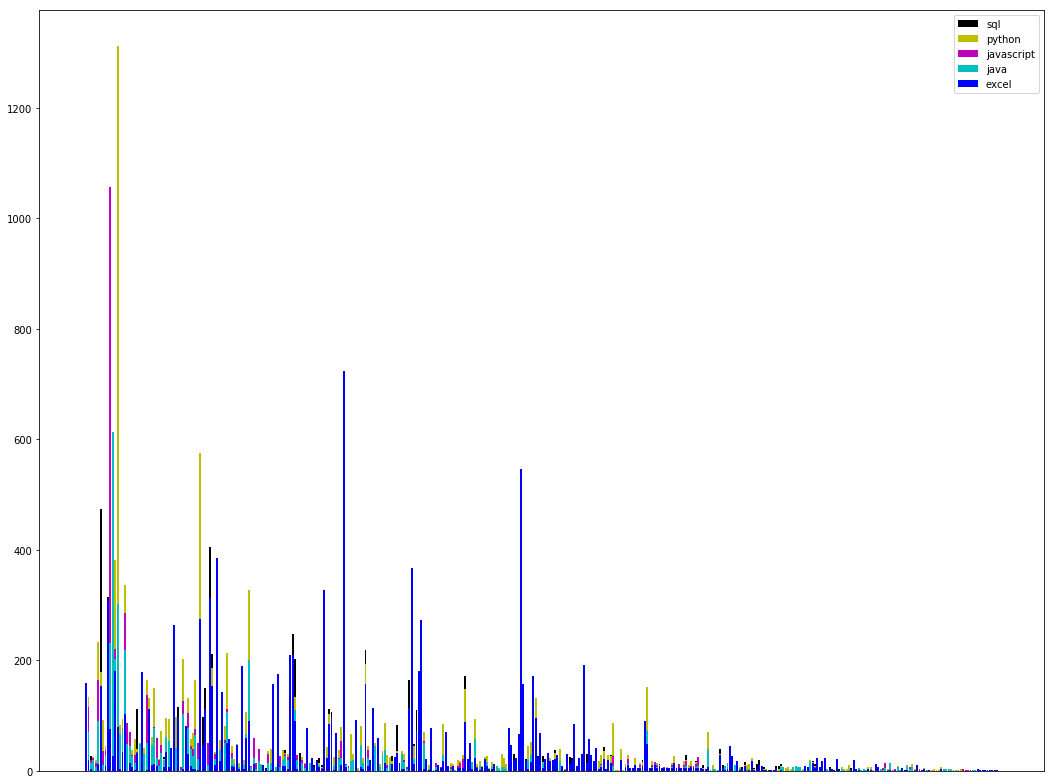

In [19]:
colors = list("rgbcmyk")
fig1, ax1 = plt.subplots()
fig1.set_size_inches(18,14)

for data_dict in all_matches.values():
   x = data_dict.keys()
   y = data_dict.values()
   plt.bar(x,y,color=colors.pop())

plt.legend(all_matches.keys())
plt.xticks([])
plt.show()

In [20]:
for skill, c in all_matches.items():
    most_common = c.most_common(20)
    print(skill, "SUMMARY:")
    print('~~~~~~~~~~~~~~~~~~')
    for item, freq in most_common:
        print(item, "+" * (freq//10))
    print()

sql SUMMARY:
000000000000000
analysis +++++++++++++++++++++++++++++++++++++++++++++++++++++++++
sql +++++++++++++++++++++++++++++++++++++++++++++++
analytics ++++++++++++++++++++++++++++++++++++++++
python +++++++++++++++++++++++++++++++++++
development +++++++++++++++++++++++++++++++
engineering +++++++++++++++++++++++++++++
communication +++++++++++++++++++++++++++
software +++++++++++++++++++++++++++
analyze +++++++++++++++++++++++++
analysts ++++++++++++++++++++++++
web ++++++++++++++++++++++++
programming ++++++++++++++++++++++++
javascript ++++++++++++++++++++++++
modeling +++++++++++++++++++++++
analyst ++++++++++++++++++++++
design +++++++++++++++++++++
statistics +++++++++++++++++++++
analytical ++++++++++++++++++++
agile ++++++++++++++++++++
visualization +++++++++++++++++

python SUMMARY:
000000000000000
python +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
engineering ++++++++++++++++++++++

In [24]:
for skill, c in all_matches.items():
    most_common = c.most_common(50)
    print(skill, "SUMMARY:")
    print('~~~~~~~~~~~~~~~~~~')
    for item, freq in most_common:
        print(item, (freq//10))
    print()

sql SUMMARY:
~~~~~~~~~~~~~~~~~~
analysis 57
sql 47
analytics 40
python 35
development 31
engineering 29
communication 27
software 27
analyze 25
analysts 24
web 24
programming 24
javascript 24
modeling 23
analyst 22
design 21
statistics 21
analytical 20
agile 20
visualization 17
java 16
bi 16
excel 15
database 14
manage 14
it 14
models 13
mathematics 12
leadership 11
databases 11
access 11
server 11
statistical 11
tableau 11
research 10
analytic 10
coding 10
ms 9
economics 9
oracle 9
planning 9
interpersonal 9
writing 8
matlab 8
developer 8
etl 8
code 8
collaborate 8
linux 7
optimization 7

python SUMMARY:
~~~~~~~~~~~~~~~~~~
python 131
engineering 57
javascript 45
analysis 39
software 38
web 33
programming 32
java 30
analytics 28
development 26
stack 23
engineers 21
modeling 20
backend 20
design 19
statistics 18
sql 17
communication 16
aws 16
react 16
analyze 15
matlab 15
linux 15
visualization 14
research 14
agile 13
developer 13
mathematics 13
code 13
models 13
analytical 12
analysts 

In [42]:
def tally_skill_mentions_in_job(t, skill_phrase_wl):
    
    skill_mentions_in_job = defaultdict(int)
    # tokenize the text of the description, without spans
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9#+-]+')
    tokens = tokenizer.tokenize(t)
    # create a dictionary of the words in the job description
    word_index = defaultdict(list)
    for i, k in enumerate(tokens):
        word_index[k].append(i)
    
    # search the word_index dictionary to find the fist word of each skill_phrase
    for skill_phrase in skill_phrase_wl:
        if word_index.get(skill_phrase[0]):
            for occurence in word_index.get(skill_phrase[0]):
                # Check to see if the whole phrase matches
                if len(tokens) > (occurence + len(skill_phrase)):
                    if all((skill_phrase[j] == tokens[j+occurence]) for j in range(len(skill_phrase))):
                        skill_mentions_in_job[tuple(skill_phrase)] += 1
    return skill_mentions_in_job        

In [43]:
tallied_skill_mentions = []
skill_dict = {tuple(skill_phrase): 0 for skill_phrase in skills['WL'].values}
for t in tqdm(all_jobs['job_summary']):
    if type(t) == str:
        tallied_skill_mentions.append(tally_skill_mentions_in_job(t, skill_dict))
    else:
        tallied_skill_mentions.append(defaultdict(int))
df = pd.DataFrame(tallied_skill_mentions, index=all_jobs.index).fillna(0).astype(int)
skills_mentioned = df.columns.values
skill_phrases_mentioned = [' '.join(c) for c in df.columns.values]
df.columns = skill_phrases_mentioned

100%|████████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 6971.98it/s]


In [44]:
my_skill_list = [' '.join(wl) for wl in skills['WL'][skills['I Have It']]]
masked = df[my_skill_list]

In [45]:
# Here is a list comprehension of skill phrases mentioned more than twice
[skill_phrase for skill_phrase, usage in df.sum(axis = 0).items() if usage > 2]

['A B',
 'AI',
 'APIs',
 'AR',
 'AWS',
 'Access',
 'Adobe',
 'After Effects',
 'Agile',
 'Android',
 'Angular',
 'AngularJS',
 'Ansible',
 'Apache',
 'BI',
 'BS',
 'Bachelor s degree',
 'Bootstrap',
 'Business Intelligence',
 'C',
 'C#',
 'C++',
 'CMS',
 'CRM',
 'CS',
 'CSS',
 'CSS3',
 'Continuous Integration',
 'Customer Relationship Management',
 'D3',
 'Database',
 'Django',
 'Django Rest Framework',
 'Docker',
 'English',
 'Facebook',
 'Git',
 'Google Analytics',
 'Google Cloud',
 'GraphQL',
 'Gulp',
 'HTML',
 'HTML5',
 'Illustrator',
 'Instagram',
 'JQuery',
 'JS',
 'JSON',
 'Java',
 'JavaScript',
 'LAMP',
 'LinkedIn',
 'Linux',
 'Math',
 'Microsoft Office',
 'MongoDB',
 'MySQL',
 'NET',
 'NGINX',
 'Node',
 'Oracle',
 'PHP',
 'Photoshop',
 'PostgreSQL',
 'Postgres',
 'PowerPoint',
 'Python',
 'QA',
 'RESTful',
 'RESTful APIs',
 'React',
 'React Native',
 'Redis',
 'Ruby',
 'Ruby on Rails',
 'SASS',
 'SEO',
 'SQL',
 'SQL Server',
 'SVG',
 'SaaS',
 'Scala',
 'SharePoint',
 'Sitecore

In [46]:
# Writes out the skills used more than twice to a csv file
with open('skill_phrases_out.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    for skill_phrase, usage in df.sum(axis = 0).items():
        if (usage > 2):
            csv_writer.writerow([skill_phrase])


In [47]:
all_jobs['Total Mentions of Skills Required'] = df.sum(axis = 1)
all_jobs['Total Mentions of Skills I Have'] = masked.sum(axis = 1)
all_jobs['Skills Required'] = df.gt(0).sum(axis=1)
all_jobs['Skills I Have'] = masked.gt(0).sum(axis=1)
for skill in ['Total Mentions of Skills Required', 'Total Mentions of Skills I Have', 'Skills Required', 'Skills I Have']:
    all_jobs[skill] = all_jobs[skill].fillna(0).astype(int)

all_jobs['Percentage of Skills'] = masked.astype(bool).sum(axis=1) / df.astype(bool).sum(axis=1)
all_jobs['Percentage of Mentions'] = masked.sum(axis = 1) / df.sum(axis = 1)

In [48]:
top_jobs = all_jobs.sort_values('Skills I Have',ascending=False).head(5)
top_jobs

company  \
data_scienceBoulder_82c5e27e77990fa2b82fa327f73...               Ball Aerospace   
data_scienceBoulder_82c5e27e77990fa2d4a3bc2fe81...               Ball Aerospace   
data_scienceBoulder_82c5e27e77990fa28366fbc45ec...               Ball Aerospace   
data_scienceBoulder_5f089617d3215642221c5f24699...  Blackstone Technology Group   
data_scienceBoulder_50208b5bf45ee3b822db494c897...                    Honeywell   

                                                                location  \
data_scienceBoulder_82c5e27e77990fa2b82fa327f73...           Boulder, CO   
data_scienceBoulder_82c5e27e77990fa2d4a3bc2fe81...           Boulder, CO   
data_scienceBoulder_82c5e27e77990fa28366fbc45ec...           Boulder, CO   
data_scienceBoulder_5f089617d3215642221c5f24699...           Boulder, CO   
data_scienceBoulder_50208b5bf45ee3b822db494c897...  Broomfield, CO 80021   

                                                                                             jobtitle  \
data_scienceBoulder_82c5e27e77990fa2b82fa327f73...  Principal Embedded Software Systems Engineer (...   
data_scienceBoulder_82c5e27e77990fa2d4a3bc2fe81...         Senior Embedded Software Engineer (662639)   
data_scienceBoulder_82c5e27e77990fa28366fbc45ec...              Embedded Software Engineer I (663691)   
data_scienceBoulder_5f089617d3215642221c5f24699...                     Sr. FPGA Verification Engineer   
data_scienceBoulder_50208b5bf45ee3b822db494c897...                               Sr Software Engineer   

                                                                                          job_summary  \
data_scienceBoulder_82c5e27e77990fa2b82fa327f73...  Who We Are:\n\nBall Aerospace leads the way in...   
data_scienceBoulder_82c5e27e77990fa2d4a3bc2fe81...  Who We Are:\n\n\nBall Aerospace leads the way ...   
data_scienceBoulder_82c5e27e77990fa28366fbc45ec...  Who We Are:\n\n\nBall Aerospace leads the way ...   
data_scienceBoulder_5f089617d3215642221c5f24699...  Blackstone Staffing Services, an award winning...   
data_scienceBoulder_50208b5bf45ee3b822db494c897...  Driving Infinite Possibilities Within A Divers...   

                                                   type  \
data_scienceBoulder_82c5e27e77990fa2b82fa327f73...  NaN   
data_scienceBoulder_82c5e27e77990fa2d4a3bc2fe81...  NaN   
data_scienceBoulder_82c5e27e77990fa28366fbc45ec...  NaN   
data_scienceBoulder_5f089617d3215642221c5f24699...  NaN   
data_scienceBoulder_50208b5bf45ee3b822db494c897...  NaN   

                                                    Total Mentions of Skills Required  \
data_scienceBoulder_82c5e27e77990fa2b82fa327f73...                                 27   
data_scienceBoulder_82c5e27e77990fa2d4a3bc2fe81...                                 21   
data_scienceBoulder_82c5e27e77990fa28366fbc45ec...                                 21   
data_scienceBoulder_5f089617d3215642221c5f24699...                                 16   
data_scienceBoulder_50208b5bf45ee3b822db494c897...                                 30   

                                                    Total Mentions of Skills I Have  \
data_scienceBoulder_82c5e27e77990fa2b82fa327f73...                               23   
data_scienceBoulder_82c5e27e77990fa2d4a3bc2fe81...                               17   
data_scienceBoulder_82c5e27e77990fa28366fbc45ec...                               17   
data_scienceBoulder_5f089617d3215642221c5f24699...                               11   
data_scienceBoulder_50208b5bf45ee3b822db494c897...                               21   

                                                    Skills Required  \
data_scienceBoulder_82c5e27e77990fa2b82fa327f73...               13   
data_scienceBoulder_82c5e27e77990fa2d4a3bc2fe81...               12   
data_scienceBoulder_82c5e27e77990fa28366fbc45ec...               12   
data_scienceBoulder_5f089617d3215642221c5f24699...               12   
data_scienceBoulder_50208b5bf45ee3b822db494c897...               11   

              

In [49]:
from IPython.core.display import HTML

def highlight_phrases_from_list2(t, skills):

    # tokenize the text of the description, with spans
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9#+-]+')
    span_generator = tokenizer.span_tokenize(t)
    spans = [span for span in span_generator]
    tokens = [t[span[0]:span[1]] for span in spans]
    
#     # create a dictionary of the words, with spans as the values
#     # and another dictionary with the same keys, with the word indexes as the values
    char_span = defaultdict(list)
    word_index = defaultdict(list)
    for i, (k, span) in enumerate(zip(tokens, spans)):
        char_span[k].append(span)
        word_index[k].append(i)
    # is this useful?
#     df = pd.DataFrame({'Character Index Spans': pd.Series(char_span), 'Word Indexes': pd.Series(word_index)})

    highlight_spans = []   
    for skill_index, skill_phrase in skills['WL'].items():
        if word_index.get(skill_phrase[0]):
            for i, occurence in enumerate(word_index.get(skill_phrase[0])):
                if len(tokens) > occurence + len(skill_phrase):
                    if all((skill_phrase[j] == tokens[j+occurence]) for j in range(len(skill_phrase))):
                        if skills['I Have It'][skill_index]:
                            c = "lime"
                        else:
                            c = "red"
                        highlight_span = (spans[occurence][0], 
                                          spans[occurence + len(skill_phrase) - 1][1],
                                         c)
                        highlight_spans.append (highlight_span)

# # look up the words in our skill list in the dictionary.  List the findings as spans to be highlighted
#     for skill in single_word_skills:
#         highlight_spans += char_span[skill]

    # Sort the spans to be highlighted
    highlight_spans.sort()

    # Insert html tags to highlight the keywords
#     html_start_tag = '<font color="red">'
    html_end_tag = '</font>'
    highlighted = ''
    cursor = 0
    for span in highlight_spans:
        if (span[0] > cursor): # go forwards only, not backwards 
            if (cursor>0):
                highlighted += html_end_tag
            html_start_tag = '<font color="' + span[2] + '">'
            highlighted += t[cursor:span[0]] + \
                            html_start_tag + \
                            t[span[0]:span[1]]
        elif (span[1] > cursor):
            highlighted += t[cursor:span[1]]
        cursor = span[1]
    highlighted += html_end_tag + t[cursor:]
    display(HTML(highlighted))

In [50]:
skills = load_skills_df()
for i,job in top_jobs.iterrows():
    highlight_phrases_from_list2(job['job_summary'], skills)
    print ('\n\n')